In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

from pyspark.sql import SparkSession

## Load the data 
40 subjects, each with 10 pictures

In [2]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content')

In [3]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [4]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [5]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Visualize entire dataset

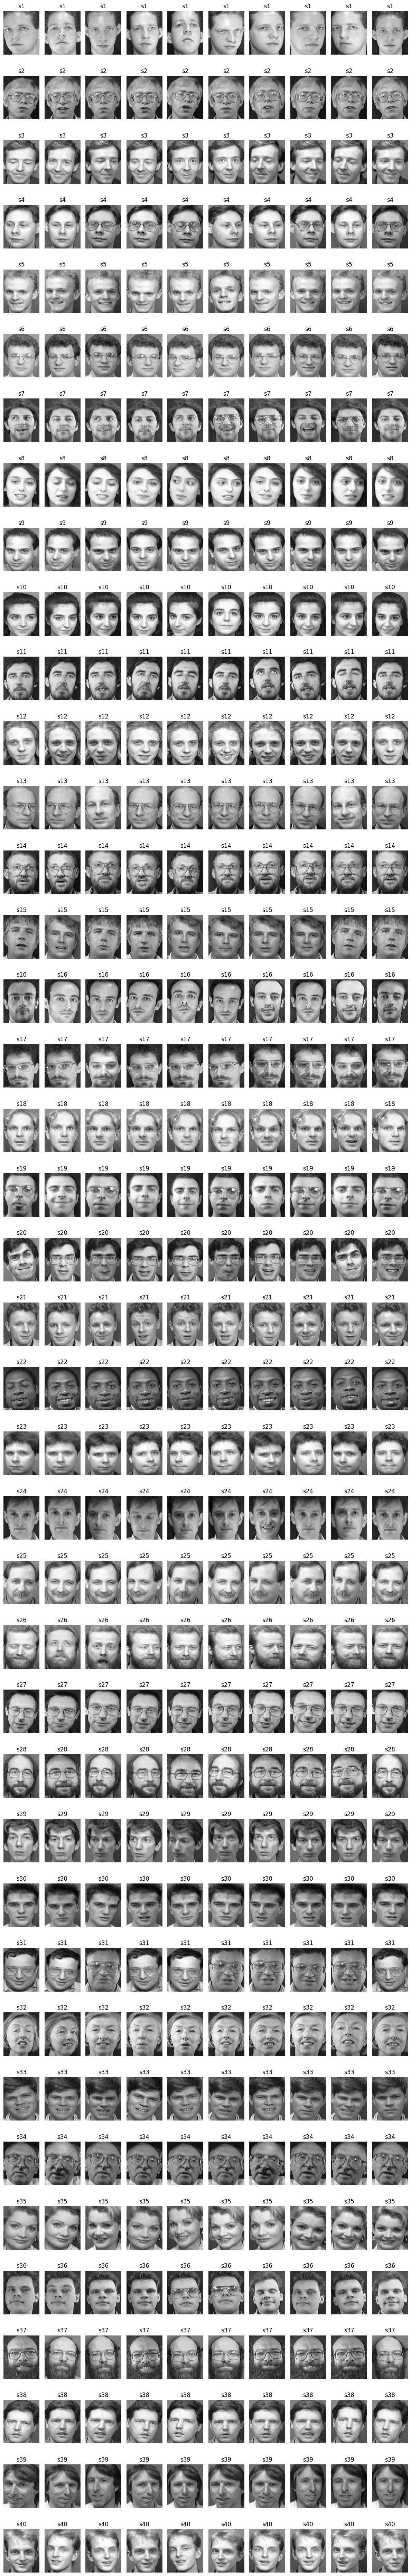

In [76]:
# View of all 400 images

# Organize the images by subject
subject_images = {}
for i in range(1, 41):
    subject = f's{i}'
    subject_images[subject] = [img for img, label in zip(X_data_original, y_data) if label == subject]

# Display all 10 images for each subject
rows = 40
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(12, 75))

for i, (subject, images) in enumerate(subject_images.items()):
    for j, img in enumerate(images):
        ax = axes[i, j]
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(subject)
        ax.axis('off')

plt.tight_layout()
plt.show()

### Check a specific subject's image set

In [7]:
# Accessing the data for a specific set of images
set_number = 's14' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

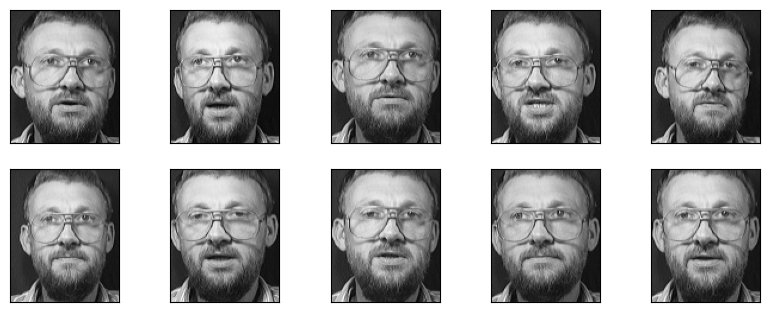

In [8]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

# Machine Learning Models

In [9]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)

## Random Forest Classifier

Reference: https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [10]:
# Assign Random Forest model 
RFmodel = RandomForestClassifier()

# Fit the Random Forest Classifier on the training data
RFmodel.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
# Make predictions on the test set
RF_y_pred = RFmodel.predict(X_test)

In [12]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Random Forest Confusion Matrix:") 
print(RFconfusion_matrix)

Random Forest Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [13]:
# Print the classification report for Random Forest model
RFclassification_report = classification_report(y_test, RF_y_pred)
print(f"Random Forest Classification Report:")
print(RFclassification_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         2
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00      1.00 

In [14]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 98.75%


In [15]:
# Finding Misclassified images in Random Forest
# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})

##Logistic Regression

In [16]:
# Scale the data for Logistic Regression
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Assign Logistic Regression model
LRmodel = LogisticRegression(max_iter=2000)

# Fit Logistic Regression model using training data
LRmodel.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [18]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test_scaled)

In [19]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [20]:
# Print the classification report for Logistic Regression model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         2
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00     

In [21]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 100.00%


In [22]:
# Finding Misclassified and Correctly Classified images in Logistic Regression
# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})

# Convolutional Neural Network (CNN) 
Reference: https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [23]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets, use random_state 1
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.2, random_state=1, stratify=y_data)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (320, 112, 92), y_train_original = (320,)
X_test_original = (80, 112, 92), y_test_original = (80,)


In [24]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (320, 112, 92, 1)
X_train_original contains 320 images
X_test_original contains 80 images


In [25]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [26]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [27]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [28]:
# Create a dataframe to store the results for model optimization
results = pd.DataFrame(columns=["Model_Version", "Test_Loss", "Test_Accuracy"])

### CNN Model Version 1 - original codeblock from referenced link

In [29]:
# Creating a sequential model named 
CNN_v1 = models.Sequential()

# Adding convolutional layer
CNN_v1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v1.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v1.add(layers.Flatten())

# Full connection
CNN_v1.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v1.add(layers.Dense(40, activation='softmax'))

In [30]:
# Compile the model
CNN_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Fit the model
history = CNN_v1.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
y_pred_v1 = CNN_v1.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v1
classification_report_v1 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v1, axis=1), zero_division=0)
print("CNN_v1 Classification Report:")
print(classification_report_v1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v1
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v1 model
CNN_v1.save("CNN_v1.h5")

Epoch 1/10
8/8 [==============================] - 2s 210ms/step - loss: 19.8000 - accuracy: 0.0312 - val_loss: 11.1064 - val_accuracy: 0.0312
Epoch 2/10
8/8 [==============================] - 1s 183ms/step - loss: 7.8414 - accuracy: 0.0547 - val_loss: 4.7787 - val_accuracy: 0.0312
Epoch 3/10
8/8 [==============================] - 3s 354ms/step - loss: 3.7428 - accuracy: 0.0547 - val_loss: 3.5706 - val_accuracy: 0.0469
Epoch 4/10
8/8 [==============================] - 2s 196ms/step - loss: 3.5140 - accuracy: 0.0625 - val_loss: 3.5961 - val_accuracy: 0.0312
Epoch 5/10
8/8 [==============================] - 2s 192ms/step - loss: 3.5407 - accuracy: 0.0625 - val_loss: 3.6044 - val_accuracy: 0.0312
Epoch 6/10
8/8 [==============================] - 2s 192ms/step - loss: 3.4239 - accuracy: 0.0664 - val_loss: 3.4867 - val_accuracy: 0.0625
Epoch 7/10
8/8 [==============================] - 2s 190ms/step - loss: 3.3565 - accuracy: 0.0938 - val_loss: 3.4634 - val_accuracy: 0.0625
Epoch 8/10
8/8 [==

<ipython-input-31-5e4559fa928d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 2 - added a convolutional layer

In [32]:
# Creating a sequential model named 
CNN_v2 = models.Sequential()

# First convolutional layer
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v2.add(layers.Flatten())

# Full connection
CNN_v2.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v2.add(layers.Dense(40, activation='softmax'))

In [33]:
# Compile the model
CNN_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Fit the model
history = CNN_v2.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
y_pred_v2 = CNN_v2.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v2
classification_report_v2 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v2, axis=1))
print("CNN_v2 Classification Report:")
print(classification_report_v2)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v2
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v2 model
CNN_v2.save("CNN_v2.h5")

Epoch 1/10
8/8 [==============================] - 3s 260ms/step - loss: 5.4620 - accuracy: 0.0273 - val_loss: 3.7182 - val_accuracy: 0.0156
Epoch 2/10
8/8 [==============================] - 2s 244ms/step - loss: 3.6545 - accuracy: 0.0430 - val_loss: 3.5595 - val_accuracy: 0.0625
Epoch 3/10
8/8 [==============================] - 2s 237ms/step - loss: 3.4198 - accuracy: 0.2031 - val_loss: 3.3476 - val_accuracy: 0.1562
Epoch 4/10
8/8 [==============================] - 2s 246ms/step - loss: 2.8810 - accuracy: 0.4492 - val_loss: 2.8892 - val_accuracy: 0.3594
Epoch 5/10
8/8 [==============================] - 3s 371ms/step - loss: 1.9752 - accuracy: 0.7188 - val_loss: 2.1312 - val_accuracy: 0.5625
Epoch 6/10
8/8 [==============================] - 2s 241ms/step - loss: 1.0285 - accuracy: 0.8750 - val_loss: 1.5303 - val_accuracy: 0.6719
Epoch 7/10
8/8 [==============================] - 2s 243ms/step - loss: 0.4507 - accuracy: 0.9453 - val_loss: 0.9773 - val_accuracy: 0.7188
Epoch 8/10
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 73ms/step - loss: 0.5391 - accuracy: 0.8875


<ipython-input-34-ace8be32a4ee>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 3 - doubled epochs from 10 to 20

In [35]:
# Creating a sequential model named 
CNN_v3 = models.Sequential()

# First convolutional layer
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v3.add(layers.Flatten())

# Full connection
CNN_v3.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.Dense(40, activation='softmax'))

In [36]:
# Compile the model
CNN_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Fit the model
history = CNN_v3.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
y_pred_v3 = CNN_v3.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v3
classification_report_v3 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v3, axis=1))
print("CNN_v3 Classification Report:")
print(classification_report_v3)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v3
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v3 model
CNN_v3.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 3s 261ms/step - loss: 5.9178 - accuracy: 0.0156 - val_loss: 3.7821 - val_accuracy: 0.0312
Epoch 2/20
8/8 [==============================] - 2s 241ms/step - loss: 3.6860 - accuracy: 0.0508 - val_loss: 3.6417 - val_accuracy: 0.0625
Epoch 3/20
8/8 [==============================] - 2s 238ms/step - loss: 3.5964 - accuracy: 0.0859 - val_loss: 3.6050 - val_accuracy: 0.0625
Epoch 4/20
8/8 [==============================] - 2s 239ms/step - loss: 3.5094 - accuracy: 0.1211 - val_loss: 3.5391 - val_accuracy: 0.0625
Epoch 5/20
8/8 [==============================] - 3s 330ms/step - loss: 3.3726 - accuracy: 0.1367 - val_loss: 3.4650 - val_accuracy: 0.0781
Epoch 6/20
8/8 [==============================] - 3s 321ms/step - loss: 3.2071 - accuracy: 0.2578 - val_loss: 3.3308 - val_accuracy: 0.0781
Epoch 7/20
8/8 [==============================] - 2s 250ms/step - loss: 3.0190 - accuracy: 0.2617 - val_loss: 3.2288 - val_accuracy: 0.2188
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 59ms/step - loss: 1.1694 - accuracy: 0.7125


<ipython-input-37-8e8af20091f0>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 4 - added a third convolutional layer

In [38]:
# Creating a sequential model named 
CNN_v4 = models.Sequential()

# First convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v4.add(layers.Flatten())

# Full connection
CNN_v4.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.Dense(40, activation='softmax'))

In [39]:
# Compile the model
CNN_v4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Fit the model
history = CNN_v4.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
y_pred_v4 = CNN_v4.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v4
classification_report_v4 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v4, axis=1))
print("CNN_v4 Classification Report:")
print(classification_report_v4)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v4
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v4 model
CNN_v4.save("CNN_v4.h5")

Epoch 1/20
8/8 [==============================] - 3s 281ms/step - loss: 3.7918 - accuracy: 0.0312 - val_loss: 3.6742 - val_accuracy: 0.0312
Epoch 2/20
8/8 [==============================] - 2s 249ms/step - loss: 3.6180 - accuracy: 0.0547 - val_loss: 3.5917 - val_accuracy: 0.0469
Epoch 3/20
8/8 [==============================] - 2s 248ms/step - loss: 3.4325 - accuracy: 0.1836 - val_loss: 3.4330 - val_accuracy: 0.1562
Epoch 4/20
8/8 [==============================] - 2s 252ms/step - loss: 3.0572 - accuracy: 0.3555 - val_loss: 3.1203 - val_accuracy: 0.2656
Epoch 5/20
8/8 [==============================] - 3s 390ms/step - loss: 2.4391 - accuracy: 0.5000 - val_loss: 2.6488 - val_accuracy: 0.3281
Epoch 6/20
8/8 [==============================] - 2s 249ms/step - loss: 1.6296 - accuracy: 0.7188 - val_loss: 1.9026 - val_accuracy: 0.5469
Epoch 7/20
8/8 [==============================] - 2s 248ms/step - loss: 0.9014 - accuracy: 0.8555 - val_loss: 1.3319 - val_accuracy: 0.6094
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 47ms/step - loss: 0.3037 - accuracy: 0.9250


<ipython-input-40-901e7df101ad>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 5 - doubled the filters in layer 2, tripled in layer 3

In [41]:
# Creating a sequential model named 
CNN_v5 = models.Sequential()

# First convolutional layer
CNN_v5.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v5.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v5.add(layers.Flatten())

# Full connection
CNN_v5.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.Dense(40, activation='softmax'))

In [42]:
# Compile the model
CNN_v5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Fit the model
history = CNN_v5.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v5.evaluate(X_test_original, y_test_encoded)
y_pred_v5 = CNN_v5.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v5
classification_report_v5 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v5, axis=1))
print("CNN_v5 Classification Report:")
print(classification_report_v5)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v5
test_loss, test_accuracy = CNN_v5.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v5", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v5 model
CNN_v5.save("CNN_v5.h5")

Epoch 1/20
8/8 [==============================] - 4s 416ms/step - loss: 5.0522 - accuracy: 0.0234 - val_loss: 3.7439 - val_accuracy: 0.0156
Epoch 2/20
8/8 [==============================] - 3s 396ms/step - loss: 3.6832 - accuracy: 0.0195 - val_loss: 3.7032 - val_accuracy: 0.0625
Epoch 3/20
8/8 [==============================] - 4s 506ms/step - loss: 3.6294 - accuracy: 0.0625 - val_loss: 3.6529 - val_accuracy: 0.0625
Epoch 4/20
8/8 [==============================] - 3s 400ms/step - loss: 3.5228 - accuracy: 0.1289 - val_loss: 3.6042 - val_accuracy: 0.1719
Epoch 5/20
8/8 [==============================] - 3s 383ms/step - loss: 3.2863 - accuracy: 0.2422 - val_loss: 3.4121 - val_accuracy: 0.1719
Epoch 6/20
8/8 [==============================] - 4s 474ms/step - loss: 2.8083 - accuracy: 0.3516 - val_loss: 3.2162 - val_accuracy: 0.1094
Epoch 7/20
8/8 [==============================] - 3s 407ms/step - loss: 2.2092 - accuracy: 0.4609 - val_loss: 2.6143 - val_accuracy: 0.2969
Epoch 8/20
8/8 [====

3/3 [==============================] - 0s 82ms/step
CNN_v5 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       0.67      1.00      0.80         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 78ms/step - loss: 0.4559 - accuracy: 0.9125


<ipython-input-43-c62640e60169>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v5", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 6 - Early Stopping and increased epochs from 20 to 50

In [44]:
from keras.callbacks import EarlyStopping

# Creating a sequential model named 
CNN_v6 = models.Sequential()

# First convolutional layer
CNN_v6.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v6.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v6.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v6.add(layers.Flatten())

# Full connection
CNN_v6.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.Dense(40, activation='softmax'))

In [45]:
# Compiling the model
CNN_v6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Setting early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Fitting the model to the training data
history = CNN_v6.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=50, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v6.evaluate(X_test_original, y_test_encoded)
y_pred_v6 = CNN_v6.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v6
classification_report_v6 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v6, axis=1))
print("CNN_v6 Classification Report:")
print(classification_report_v6)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v6
test_loss, test_accuracy = CNN_v6.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v6", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v6 model
CNN_v6.save("CNN_v6.h5")

Epoch 1/50
8/8 [==============================] - 6s 717ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.8762 - val_accuracy: 0.8281
Epoch 2/50
8/8 [==============================] - 5s 626ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.9052 - val_accuracy: 0.8281
Epoch 3/50
8/8 [==============================] - 3s 412ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.9240 - val_accuracy: 0.8125
Epoch 4/50
8/8 [==============================] - 4s 486ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.9596 - val_accuracy: 0.8125
Epoch 5/50
8/8 [==============================] - 4s 511ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9783 - val_accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 3s 396ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.9790 - val_accuracy: 0.8281
Epoch 6: early stopping
3/3 [==============================] - 0s 76ms/step
CNN_v6 Classification Report:
              precision    recall  f1-score   support


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 78ms/step - loss: 0.5478 - accuracy: 0.8875


<ipython-input-47-ba38e4042556>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v6", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 7 - Added 3rd Dense Layer

In [48]:
# Creating a sequential model named 
CNN_v7 = models.Sequential()

# First convolutional layer
CNN_v7.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v7.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v7.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v7.add(layers.Flatten())

# Full connection
CNN_v7.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))  # Third dense layer
CNN_v7.add(layers.Dense(40, activation='softmax'))

In [49]:
# Compile the model
CNN_v7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
# Fit the model
history = CNN_v7.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v7.evaluate(X_test_original, y_test_encoded)
y_pred_v7 = CNN_v7.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v7
classification_report_v7 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v7, axis=1))
print("CNN_v7 Classification Report:")
print(classification_report_v7)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v7
test_loss, test_accuracy = CNN_v7.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v7", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v7 model
CNN_v7.save("CNN_v7.h5")

Epoch 1/20
8/8 [==============================] - 7s 918ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1097 - val_accuracy: 0.8125
Epoch 2/20
8/8 [==============================] - 4s 445ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1614 - val_accuracy: 0.8125
Epoch 3/20
8/8 [==============================] - 3s 384ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1908 - val_accuracy: 0.8125
Epoch 4/20
8/8 [==============================] - 4s 518ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.2041 - val_accuracy: 0.8125
Epoch 5/20
8/8 [==============================] - 3s 395ms/step - loss: 9.2052e-04 - accuracy: 1.0000 - val_loss: 1.2125 - val_accuracy: 0.8125
Epoch 6/20
8/8 [==============================] - 3s 388ms/step - loss: 8.3485e-04 - accuracy: 1.0000 - val_loss: 1.2178 - val_accuracy: 0.7969
Epoch 7/20
8/8 [==============================] - 3s 391ms/step - loss: 7.6141e-04 - accuracy: 1.0000 - val_loss: 1.2309 - val_accuracy: 0.7969
Epoch 8/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 81ms/step - loss: 1.1048 - accuracy: 0.8375


<ipython-input-51-1b537338738d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v7", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


##CNN Model Version 8 - Added a Dropout Layer, increased dense layer neurons 100 to 256 and 50 128

In [52]:
# Creating a sequential model named
CNN_v8 = models.Sequential()

# First convolutional layer
CNN_v8.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v8.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v8.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v8.add(layers.Flatten())

# Dropout regularization
CNN_v8.add(layers.Dropout(0.5))  

# Full connection
CNN_v8.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.Dense(40, activation='softmax'))

In [53]:
# Compile the model
CNN_v8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Fit the model
history = CNN_v8.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v8.evaluate(X_test_original, y_test_encoded)
y_pred_v8 = CNN_v8.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v8
classification_report_v8 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v8, axis=1))
print("CNN_v8 Classification Report:")
print(classification_report_v8)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v8
test_loss, test_accuracy = CNN_v8.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v8", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v8 model
CNN_v8.save("CNN_v8.h5")

Epoch 1/20
8/8 [==============================] - 4s 440ms/step - loss: 4.2051 - accuracy: 0.0352 - val_loss: 3.7265 - val_accuracy: 0.0156
Epoch 2/20
8/8 [==============================] - 4s 539ms/step - loss: 3.6696 - accuracy: 0.0312 - val_loss: 3.6856 - val_accuracy: 0.0781
Epoch 3/20
8/8 [==============================] - 3s 410ms/step - loss: 3.5874 - accuracy: 0.0664 - val_loss: 3.6385 - val_accuracy: 0.1406
Epoch 4/20
8/8 [==============================] - 3s 417ms/step - loss: 3.3024 - accuracy: 0.1719 - val_loss: 3.2034 - val_accuracy: 0.1719
Epoch 5/20
8/8 [==============================] - 3s 443ms/step - loss: 2.6660 - accuracy: 0.3164 - val_loss: 2.4293 - val_accuracy: 0.3750
Epoch 6/20
8/8 [==============================] - 4s 464ms/step - loss: 1.7064 - accuracy: 0.5977 - val_loss: 1.4857 - val_accuracy: 0.6719
Epoch 7/20
8/8 [==============================] - 3s 412ms/step - loss: 0.7674 - accuracy: 0.8477 - val_loss: 1.3174 - val_accuracy: 0.6719
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 77ms/step - loss: 0.5264 - accuracy: 0.9125


<ipython-input-54-b5748d842a34>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v8", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


## CNN Model Version 9 - building from version 4, adding 2nd dense layer with increased neurons 

In [86]:
# Creating a sequential model named 
CNN_v9 = models.Sequential()

# First convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v9.add(layers.Flatten())

# Full connection
CNN_v9.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.Dense(40, activation='softmax'))

In [87]:
# Compile the model
CNN_v9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
# Fit the model
history = CNN_v9.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v9.evaluate(X_test_original, y_test_encoded)
y_pred_v9 = CNN_v9.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v9
classification_report_v9 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v9, axis=1))
print("CNN_v9 Classification Report:")
print(classification_report_v9)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v9
test_loss, test_accuracy = CNN_v9.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v9", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v9 model
CNN_v9.save("CNN_v9.h5")

Epoch 1/20
8/8 [==============================] - 6s 734ms/step - loss: 9.1996e-04 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 0.9062
Epoch 2/20
8/8 [==============================] - 2s 261ms/step - loss: 8.2629e-04 - accuracy: 1.0000 - val_loss: 0.3405 - val_accuracy: 0.9219
Epoch 3/20
8/8 [==============================] - 3s 404ms/step - loss: 7.4738e-04 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.9219
Epoch 4/20
8/8 [==============================] - 2s 260ms/step - loss: 6.8430e-04 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9219
Epoch 5/20
8/8 [==============================] - 2s 258ms/step - loss: 6.3201e-04 - accuracy: 1.0000 - val_loss: 0.3413 - val_accuracy: 0.9062
Epoch 6/20
8/8 [==============================] - 2s 266ms/step - loss: 5.8513e-04 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9062
Epoch 7/20
8/8 [==============================] - 2s 264ms/step - loss: 5.5001e-04 - accuracy: 1.0000 - val_loss: 0.3399 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 50ms/step - loss: 0.1822 - accuracy: 0.9375


<ipython-input-89-cc20724cc293>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v9", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


## CNN Model Version 10 - !! Alter Architecture !!

In [ ]:
# Creating a sequential model named 
CNN_v10 = models.Sequential()

# First convolutional layer
CNN_v10.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v10.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v10.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v10.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v10.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v10.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v10.add(layers.Flatten())

# Full connection
CNN_v10.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_v10.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
CNN_v10.add(layers.Dense(40, activation='softmax'))

In [ ]:
# Compile the model
CNN_v10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
history = CNN_v10.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v10.evaluate(X_test_original, y_test_encoded)
y_pred_v10 = CNN_v10.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v10
classification_report_v10 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v10, axis=1))
print("CNN_v10 Classification Report:")
print(classification_report_v10)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v9
test_loss, test_accuracy = CNN_v10.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v10", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v10 model
CNN_v10.save("CNN_v10.h5")

Epoch 1/20
8/8 [==============================] - 6s 734ms/step - loss: 9.1996e-04 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 0.9062
Epoch 2/20
8/8 [==============================] - 2s 261ms/step - loss: 8.2629e-04 - accuracy: 1.0000 - val_loss: 0.3405 - val_accuracy: 0.9219
Epoch 3/20
8/8 [==============================] - 3s 404ms/step - loss: 7.4738e-04 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.9219
Epoch 4/20
8/8 [==============================] - 2s 260ms/step - loss: 6.8430e-04 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9219
Epoch 5/20
8/8 [==============================] - 2s 258ms/step - loss: 6.3201e-04 - accuracy: 1.0000 - val_loss: 0.3413 - val_accuracy: 0.9062
Epoch 6/20
8/8 [==============================] - 2s 266ms/step - loss: 5.8513e-04 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9062
Epoch 7/20
8/8 [==============================] - 2s 264ms/step - loss: 5.5001e-04 - accuracy: 1.0000 - val_loss: 0.3399 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 50ms/step - loss: 0.1822 - accuracy: 0.9375


<ipython-input-89-cc20724cc293>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v9", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


In [90]:
print(results)

  Model_Version  Test_Loss  Test_Accuracy
0        CNN_v1   3.321618         0.0875
1        CNN_v2   0.539116         0.8875
2        CNN_v3   1.169412         0.7125
3        CNN_v4   0.303663         0.9250
4        CNN_v5   0.455867         0.9125
5        CNN_v6   0.547780         0.8875
6        CNN_v7   1.104761         0.8375
7        CNN_v8   0.526422         0.9125
8        CNN_v9   0.182211         0.9375


In [95]:
# Get the predicted labels for the test set from the best performing CNN model
y_pred_cnn_v9 = np.argmax(y_pred_v9, axis=1)

# Calculate the balanced accuracy score for CNN Version 9
balanced_acc_best = balanced_accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred_cnn_v9)

# Print the balanced accuracy score for CNN Version 9
print(f"CNN Version 9 Balanced Accuracy: {balanced_acc_best * 100:.2f}%")

CNN Version 9 Balanced Accuracy: 93.75%


### Visualizations for CNN Model Versions

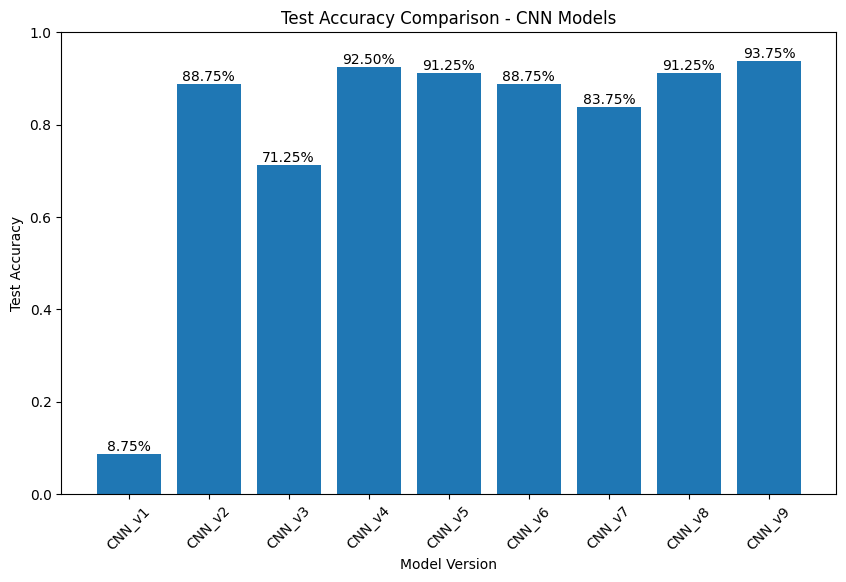

In [92]:
plt.figure(figsize=(10, 6))
bars = plt.bar(results["Model_Version"], results["Test_Accuracy"])
plt.xlabel("Model Version")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - CNN Models")
plt.ylim([0, 1])
plt.xticks(rotation=45)

# Add the test accuracy values on top of each bar
for i, rect in enumerate(bars):
    height = rect.get_height()
    test_accuracy = results["Test_Accuracy"][i]
    plt.text(rect.get_x() + rect.get_width() / 2, height, f"{test_accuracy:.2%}", ha="center", va="bottom")

plt.show()

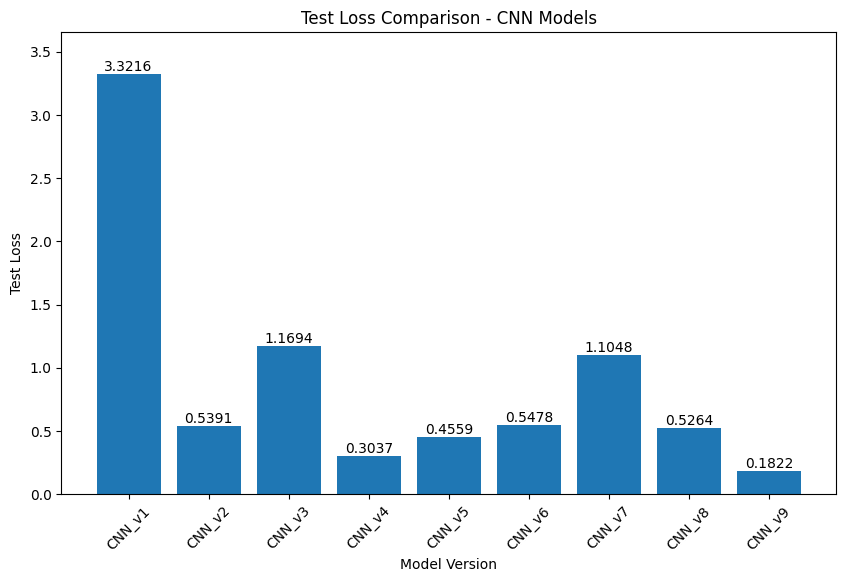

In [93]:
plt.figure(figsize=(10, 6))
bars = plt.bar(results["Model_Version"], results["Test_Loss"])
plt.xlabel("Model Version")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison - CNN Models")
plt.ylim([0, max(results["Test_Loss"]) * 1.1])
plt.xticks(rotation=45)

# Add the test loss values on top of each bar
for i, rect in enumerate(bars):
    height = rect.get_height()
    test_loss = results["Test_Loss"][i]
    plt.text(rect.get_x() + rect.get_width() / 2, height, f"{test_loss:.4f}", ha="center", va="bottom")

plt.show()

# Comparative Visualizations Across Random Forest, Logistic Regression, and CNN

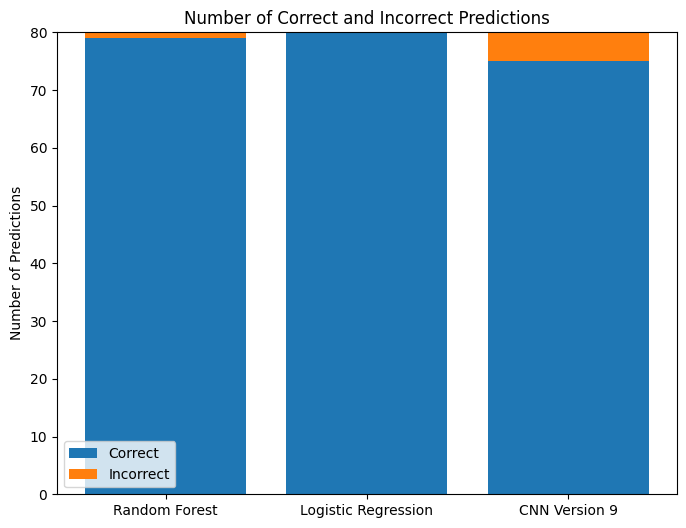

In [99]:
# Calculate number of correct and incorrect predictions for Random Forest
correct_predictions_rf = sum(y_test_array == RF_y_pred_array)
incorrect_predictions_rf = sum(y_test_array != RF_y_pred_array)

# Calculate number of correct and incorrect predictions for Logistic Regression
correct_predictions_lr = sum(y_test_array == LR_y_pred_array)
incorrect_predictions_lr = sum(y_test_array != LR_y_pred_array)

# Calculate number of correct and incorrect predictions for CNN Version 9
correct_predictions_cnn_v9 = np.sum(np.argmax(y_test_encoded, axis=1) == np.argmax(y_pred_v9, axis=1))
incorrect_predictions_cnn_v9 = np.sum(np.argmax(y_test_encoded, axis=1) != np.argmax(y_pred_v9, axis=1))

# Create stacked bar chart
labels = ["Random Forest", "Logistic Regression", "CNN Version 9"]
correct_predictions = [correct_predictions_rf, correct_predictions_lr, correct_predictions_cnn_v9]
incorrect_predictions = [incorrect_predictions_rf, incorrect_predictions_lr, incorrect_predictions_cnn_v9]

plt.figure(figsize=(8, 6))
plt.bar(labels, correct_predictions, label="Correct")
plt.bar(labels, incorrect_predictions, bottom=correct_predictions, label="Incorrect")
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions")
plt.legend(loc='lower left')
plt.show()

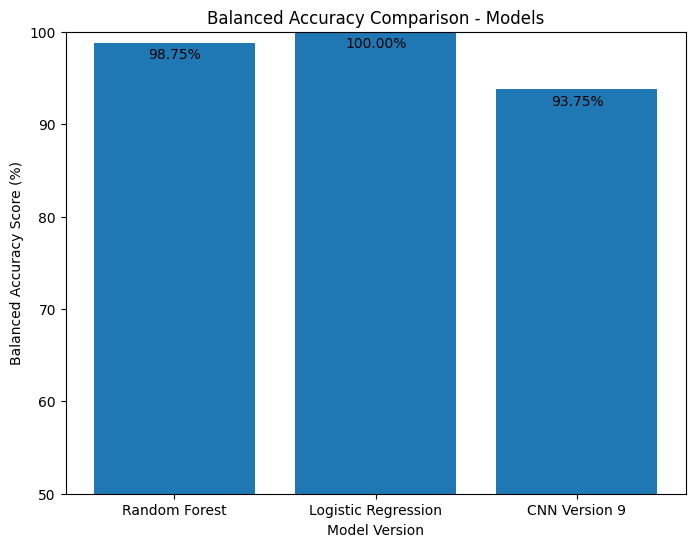

In [96]:
# Define the model versions and their corresponding balanced accuracy scores
model_versions = ['Random Forest', 'Logistic Regression', 'CNN Version 9']
balanced_accuracy_scores = [RF_balanced_accuracy_score, LR_balanced_accuracy_score, balanced_acc_best]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(model_versions, [score*100 for score in balanced_accuracy_scores])  # Convert scores to percentage
plt.ylim([50, 100])  # Set the y-axis limits to [50, 100]
plt.xlabel('Model Version')
plt.ylabel('Balanced Accuracy Score (%)')
plt.title('Balanced Accuracy Comparison - Models')

# Add the balanced accuracy scores as text (percentage) on top of each bar
for bar, score in zip(bars, balanced_accuracy_scores):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() - 2  # Adjust the vertical position of the text
    plt.text(x, y, f'{score*100:.2f}%', ha='center', va='bottom')

plt.show()

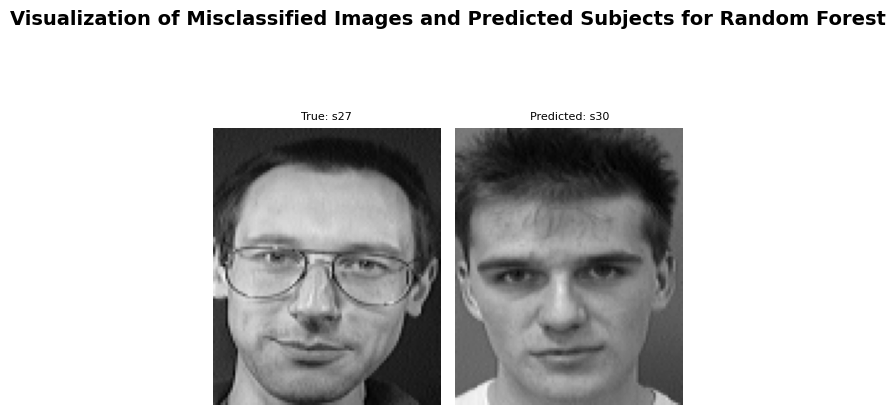

In [65]:
# Set the number of rows and columns for the subplots
rows = len(RFmisclassified)
cols = 2

# Check if rows is 0
if rows == 0:
    print("No misclassified images for Random Forest.")
else:
    # Adjust the number of columns if there are not enough columns to accommodate the plots
    if cols < 2:
        cols = 2

    # Create the subplot grid
    if rows == 1:
        fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
        axes = np.expand_dims(axes, axis=0)  # Convert axes to a 2-dimensional array
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Iterate through misclassified images and display the corresponding images
    for i, index in enumerate(RFmisclassified):
        img = X_test[index]
        true_label = y_test_array[index]
        pred_label = RF_y_pred_array[index]

        # Find the index of the first image for the predicted subject
        predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
        predicted_subject_image = X_test[predicted_subject_index]

        # Calculate the row and column index for the subplot axes
        row = i
        col = 0

        # Plot the true subject image
        axes[row, col].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col].set_title(f"True: {true_label}", fontsize=8)
        axes[row, col].axis('off')

        # Plot the predicted subject image
        axes[row, col + 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col + 1].set_title(f"Predicted: {pred_label}", fontsize=8)
        axes[row, col + 1].axis('off')

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Random Forest", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [66]:
# Set the number of columns for the subplots
cols = 2

# Calculate the number of rows required based on the number of misclassified images
rows = (len(LRmisclassified) + 1) // cols

# Check if rows is 0
if rows == 0:
    print("No misclassified images.")
else:
    # Create the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

    # Reshape axes to a 2-dimensional array if there is only one row
    if rows == 1:
        axes = np.array([axes])

    # Iterate through misclassified indices and display the corresponding images
    for i, index in enumerate(LRmisclassified):
        img = X_test[index]
        true_label = y_test_array[index]
        pred_label = LR_y_pred[index]

        # Find the index of the first image for the predicted subject
        predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
        predicted_subject_image = X_test[predicted_subject_index]

        # Calculate the row and column index for the subplot axes
        row = i // cols
        col = i % cols

        # Plot the true subject image
        axes[row, col].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col].set_title(f"True: {true_label}", fontsize=8)
        axes[row, col].axis('off')

        # Plot the predicted subject image
        axes[row, col + 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col + 1].set_title(f"Predicted: {pred_label}", fontsize=8)
        axes[row, col + 1].axis('off')

    # Adjust the layout and spacing between subplots
    plt.tight_layout()

    # Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
    if len(LRmisclassified) % cols != 0:
        for i in range(len(LRmisclassified) % cols + 1, cols):
            fig.delaxes(axes[-1, i])

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Logistic Regression", fontsize=14, fontweight='bold')
    plt.show()

No misclassified images.


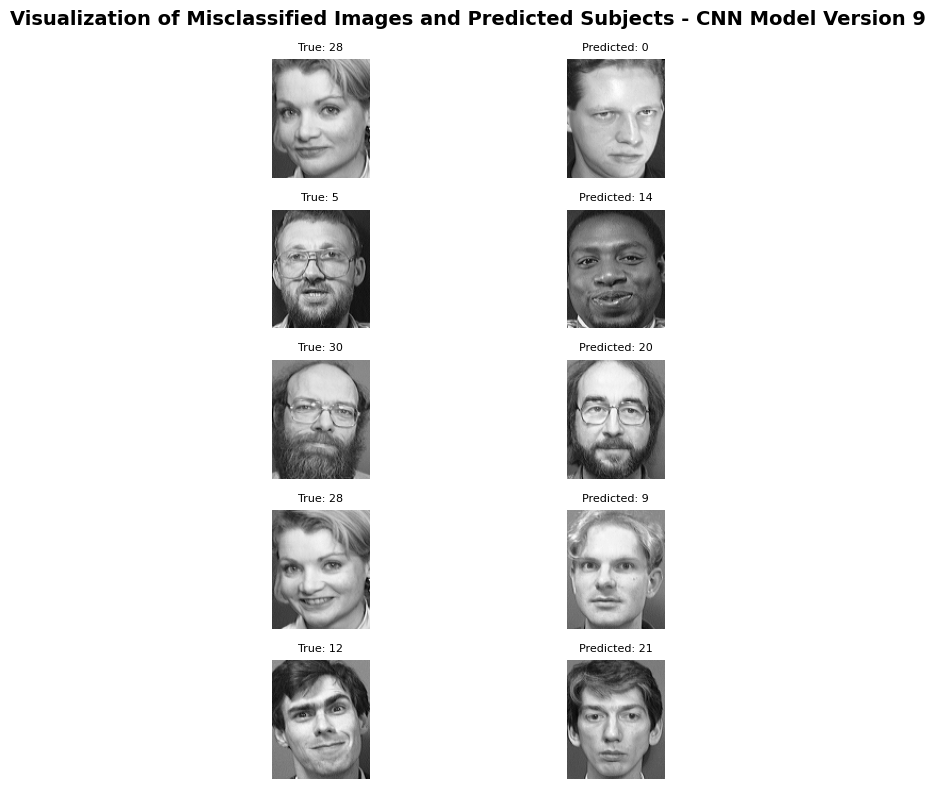

In [100]:
# Calculate misclassified indices for CNN Model Version 9
misclassified_cnn_v9 = np.where(np.argmax(y_pred_v4, axis=1) != np.argmax(y_test_encoded, axis=1))[0]

# Set the number of rows and columns for the subplots
rows_cnn_v9 = len(misclassified_cnn_v9)
cols = 2

# Check if rows_cnn_v9 is zero
if rows_cnn_v9 == 0:
    print("No misclassified images for CNN Model Version 9.")
else:
    # Create the subplot grid
    fig, axes = plt.subplots(rows_cnn_v9, cols, figsize=(8, 8))

    # Iterate through CNN Model Version 9 misclassified images and display the corresponding images
    for i, index in enumerate(misclassified_cnn_v9):
        img = X_test_original[index]
        true_label = np.argmax(y_test_encoded[index])
        pred_label = np.argmax(y_pred_v4[index])

        # Find the indices of images for the predicted subject
        predicted_subject_indices = np.where(np.argmax(y_test_encoded, axis=1) == pred_label)[0]

        # Check if there are any images available for the predicted subject
        if len(predicted_subject_indices) > 0:
            # Retrieve the first image of the predicted subject
            predicted_subject_index = predicted_subject_indices[0]
            predicted_subject_image = X_test_original[predicted_subject_index]

            # Plot the true subject image
            axes[i, 0].imshow(img, cmap=plt.cm.gray)
            axes[i, 0].set_title(f"True: {true_label}", fontsize=8)
            axes[i, 0].axis('off')

            # Plot the predicted subject image
            axes[i, 1].imshow(predicted_subject_image, cmap=plt.cm.gray)
            axes[i, 1].set_title(f"Predicted: {pred_label}", fontsize=8)
            axes[i, 1].axis('off')

    # Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
    if rows_cnn_v9 % cols != 0:
        for i in range(rows_cnn_v9 % cols + 1, cols):
            fig.delaxes(axes[-1, i])

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects - CNN Model Version 9", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### PySpark 

In [68]:
# Initialize a dictionary to hold average pixel intensities for each of the 40 individuals (class)
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for {class_name}: {avg_intensity}")

Average pixel intensity for s33: 92.42089479813664
Average pixel intensity for s36: 111.48193905279501
Average pixel intensity for s30: 99.23293866459626
Average pixel intensity for s40: 123.42201086956523
Average pixel intensity for s14: 102.43626746894411
Average pixel intensity for s9: 113.32507763975154
Average pixel intensity for s11: 102.36776979813665
Average pixel intensity for s2: 112.65321234472049
Average pixel intensity for s23: 111.16773097826088
Average pixel intensity for s3: 115.87922166149067
Average pixel intensity for s31: 106.60304736024845
Average pixel intensity for s19: 120.02870729813667
Average pixel intensity for s32: 125.42356366459626
Average pixel intensity for s4: 118.67832880434783
Average pixel intensity for s22: 85.1676921583851
Average pixel intensity for s25: 124.24754464285714
Average pixel intensity for s10: 104.09259510869565
Average pixel intensity for s1: 136.7014072204969
Average pixel intensity for s24: 103.14790372670807
Average pixel intensit

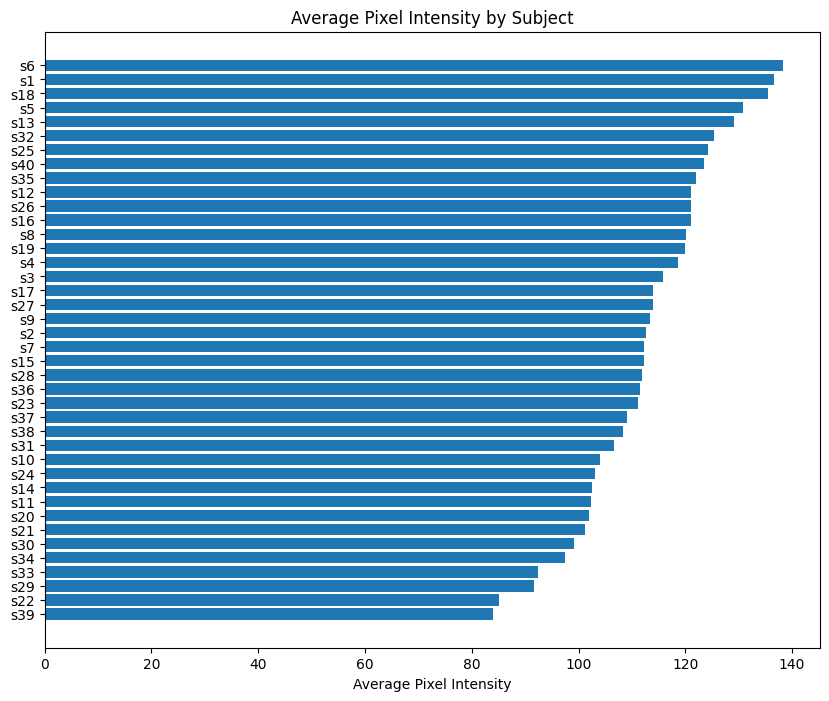

In [69]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

In [70]:
# Convert average_pixel_intensities dictionary to a list of tuples
data = [(str(subject), float(avg_intensity)) for subject, avg_intensity in average_pixel_intensities.items()]

# Create Spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

# Create DataFrame from the list of tuples
avg_pixel_df = spark.createDataFrame(data, ["Subject", "Average Pixel Intensity"])

# Sort the DataFrame by 'Average Pixel Intensity'
avg_pixel_df = avg_pixel_df.orderBy('Average Pixel Intensity')

# Show the DataFrame
avg_pixel_df.show()

+-------+-----------------------+
|Subject|Average Pixel Intensity|
+-------+-----------------------+
|    s39|      83.92661102484473|
|    s22|       85.1676921583851|
|    s29|      91.63590838509317|
|    s33|      92.42089479813664|
|    s34|      97.42004076086957|
|    s30|      99.23293866459626|
|    s21|     101.22831909937887|
|    s20|     101.92547554347826|
|    s11|     102.36776979813665|
|    s14|     102.43626746894411|
|    s24|     103.14790372670807|
|    s10|     104.09259510869565|
|    s31|     106.60304736024845|
|    s38|     108.30481366459628|
|    s37|      109.1043963509317|
|    s23|     111.16773097826088|
|    s36|     111.48193905279501|
|    s28|     111.90132958074534|
|    s15|     112.20925854037266|
|     s7|     112.24663237577639|
+-------+-----------------------+
only showing top 20 rows

